#  <span style="color:purple">Projeto - Mineração de texto com stack ELK [22E2_3]</span>

**Erik Tavares dos Anjos** <br />
**Date Updated: 23/06/2022** <br />
**GIT: https://github.com/eriktavares/projeto_minera-o_texto_elasticksearch**

##  <span style="color:purple">1. Cenário</span>

O dataset abaixo está disponível no site kaggle pela URL abaixo.

**News Category Dataset </br>
Identify the type of news based on headlines and short descriptions </br>
https://www.kaggle.com/datasets/rmisra/news-category-dataset.** </br>

Context </br>
This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The model trained on this dataset could be used to identify tags for untracked news articles or to identify the type of language used in different news articles.

### 1.1 - Leitura do Dataset

O dataset tras 6 colunas 'category', 'headline', 'authors', 'link', 'short_description', 'date'.

**category**: Categória em que a notícia é classificada. </br>
**headline**: Título da Notícia. </br>
**authors**: Autores. </br>
**link**: Link para o site. </br>
**short_description**: Descrição curta, ou um resumo da notícia.</br>
**date**: Data da publicação. </br>

In [156]:
import pandas as pd
df_data = pd.read_json('../Data/archive5zip/News_Category_Dataset_v2.json', orient='records', lines=True)
df_data.head(1).T

,0
category,CRIME
headline,There Were 2 Mass Shootings In Texas Last Week...
authors,Melissa Jeltsen
link,https://www.huffingtonpost.com/entry/texas-ama...
short_description,She left her husband. He killed their children...
date,2018-05-26 00:00:00


### 1.1.1.Categoria

São diversas categórias, como Politica, Bem estar, Enterterimento, Viagens, Stylo e Beleza, e diversas outras. O tipo de dado é um 
keyword, uma palavra chave.

In [157]:
df_data['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

### 1.1.2 Demais Colunas

O **headline** é o título da notícia, abaixo impresso em negrito, e o **short_description** é
a descrição cruta, ambos são textos curtos e que foram um resumo do que será o assunto da notícia. 
Os campos Author, tras o nome do autor da noticia e tem o tipo keywork. A data de publicação está no formato data e o link no formato texto

Abaixo estão alguns exemplos
de notícias (5 primeiras do dataset)

In [3]:
BOLD = '\033[1m'
NORMAL = '\033[0m'

for i in range(0,5):
    print("----------------------------------------------------------------")
    print("Notícia {}:".format(i))
    print(BOLD+df_data['headline'].iloc[i]+'\n'+NORMAL+df_data['short_description'].iloc[i])
    print(df_data['authors'].iloc[i], df_data['date'].iloc[i])
    print(df_data['link'].iloc[i], '\n')

----------------------------------------------------------------
Notícia 0:
There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV
She left her husband. He killed their children. Just another day in America.
Melissa Jeltsen 2018-05-26 00:00:00
https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89 

----------------------------------------------------------------
Notícia 1:
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
Of course it has a song.
Andy McDonald 2018-05-26 00:00:00
https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201 

----------------------------------------------------------------
Notícia 2:
Hugh Grant Marries For The First Time At Age 57
The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.
Ron Dicker 2018-05-26 00:00:00
https://www.huffingtonpost.com/entry/hugh-grant-m

##  <span style="color:purple">2. Pré Processamento</span>

Esses dados serão migrados para o banco de dados Elasticsearch 8.2.2. para isso será realizado a analise dos campos para posteriormente realizar a criação do mapeamento.

**Elasticsearch** </br>
o Elasticsearch é um mecanismo de busca e análise de dados distribuído, gratuito e aberto para todos os tipos de dados, incluindo textuais, numéricos, geoespaciais, estruturados e não estruturados. O Elasticsearch é desenvolvido sobre o Apache Lucene e foi lançado pela primeira vez em 2010 pela Elasticsearch N.V. (agora conhecida como Elastic). Conhecido por suas REST APIs simples, natureza distribuída, velocidade e escalabilidade, o Elasticsearch é o componente central do Elastic Stack, um conjunto de ferramentas gratuitas e abertas para ingestão, enriquecimento, armazenamento, análise e visualização de dados. Comumente chamado de ELK Stack (pelas iniciais de Elasticsearch, Logstash e Kibana), o Elastic Stack agora inclui uma rica coleção de agentes lightweight conhecidos como Beats para enviar dados ao Elasticsearch.[https://www.elastic.co/pt/what-is/elasticsearch]

In [5]:
import elasticsearch
import getpass
import urllib3
urllib3.disable_warnings()
senha = getpass.getpass("Digite sua senha: ")

ES_URL = 'https://localhost:9200'
ES_USER = 'elastic'
ES_PASS = senha

client = elasticsearch.Elasticsearch(
    ES_URL,
    basic_auth=(ES_USER, ES_PASS),
    verify_certs=False
)
dict(client.info())

Digite sua senha: ········


C:\ProgramData\Anaconda3\lib\site-packages\elasticsearch\_sync\client\__init__.py:395: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


{'name': 'DESKTOP-4SAUDI3',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'HTrqKXa6SSyS9cJuvdjf4A',
 'version': {'number': '8.2.2',
  'build_flavor': 'default',
  'build_type': 'zip',
  'build_hash': '9876968ef3c745186b94fdabd4483e01499224ef',
  'build_date': '2022-05-25T15:47:06.259735307Z',
  'build_snapshot': False,
  'lucene_version': '9.1.0',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

### 2.1 Analizer

Text analysis enables Elasticsearch to perform full-text search, where the search returns all relevant results rather than just exact matches [https://www.elastic.co/guide/en/elasticsearch/reference/8.2/analysis-overview.html].

Nesta sessão será realizado a implementação de um analizador para ser aplicado aos campos headline e short_description das noticias.

Para iniciar, será feito o carregamento das stop words em ingles do nltk, essas stop words são palavras que não agregam para resultados de analises de texto.



In [6]:
import nltk
stop_words_en=nltk.corpus.stopwords.words('english')
print(' , '.join([x for x in stop_words_en]))

i , me , my , myself , we , our , ours , ourselves , you , you're , you've , you'll , you'd , your , yours , yourself , yourselves , he , him , his , himself , she , she's , her , hers , herself , it , it's , its , itself , they , them , their , theirs , themselves , what , which , who , whom , this , that , that'll , these , those , am , is , are , was , were , be , been , being , have , has , had , having , do , does , did , doing , a , an , the , and , but , if , or , because , as , until , while , of , at , by , for , with , about , against , between , into , through , during , before , after , above , below , to , from , up , down , in , out , on , off , over , under , again , further , then , once , here , there , when , where , why , how , all , any , both , each , few , more , most , other , some , such , no , nor , not , only , own , same , so , than , too , very , s , t , can , will , just , don , don't , should , should've , now , d , ll , m , o , re , ve , y , ain , aren , 

**Analizer**
O analiser é o conjunto de char_filter, tokenizer e token filter, de forma simplificada.


**Tokenizer**
Standard tokenizeredit
The standard tokenizer provides grammar based tokenization (based on the Unicode Text Segmentation algorithm, as specified in Unicode Standard Annex #29) and works well for most languages [https://www.elastic.co/guide/en/elasticsearch/reference/8.2/analysis-standard-tokenizer.html].

De forma simplificada, os tokens são separados por espaço, não
há remoção de número ou de apostrofe. Conforme, exemplo abaixo de um texto do dataset.

In [7]:
analyzed = client.indices.analyze(
        tokenizer="standard",
        text="Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song"
)
print([x["token"] for x in analyzed['tokens']])

['Will', 'Smith', 'Joins', 'Diplo', 'And', 'Nicky', 'Jam', 'For', 'The', '2018', 'World', "Cup's", 'Official', 'Song']


Para remorada dos números será utilizado Char filter.

**Char filter**
Os filtros de caracteres são usados ​​para pré-processar o fluxo de caracteres antes que ele seja passado para o tokenizador. No analisardor desenvolvido, possui um char_filter para remoção de números, como são textos de noticias, são é necessário que os números virem tokens.

**Token filter**
Os token filter ja modificam os tokens após o tokenizer. Para o analizador, será utilizado token filter "lowercase", "asciifolding", "apostrophe" e "stop_custom". O lowercase para passar as letras para minusculas dos tokens. O asciifolding remove acentos e caracteres especiais. O Apostrophe é para remoção de apostrophe dos tokens, como em [cup's] --> [cup]. Por ultimo, o custom stop words para utilização das stop words do nltk. 

In [8]:
INDICE_NAME = 'category_index'


analysis={
          "analyzer": {
            "analizer_text": { 
                  "char_filter": [
                    "replace_numbers"
                    ],
                  "tokenizer": "standard",
                  "filter": [
                      "lowercase",
                      "asciifolding",
                      "apostrophe",
                      "stop_custom",
                  ]
                }
              },
          "char_filter": {
             "replace_numbers": {
                    "type": "pattern_replace",
                    "pattern": "([0-9]+)",
                    "replacement": ""
             },
          },
          "filter": {
            "english_stop": { 
              "type": "stop",
              "stopwords": "_english_"
            },
            "stop_custom": {
                "type": "stop",
                "stopwords": stop_words_en,
        },
    }
}

text_category_analizer = {   
    "settings": {
        "analysis": analysis
      }
    }
    
if client.indices.exists(index=INDICE_NAME):
    client.indices.delete(index=INDICE_NAME)
client.indices.create(index=INDICE_NAME, **text_category_analizer)



ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'category_index'})

O resultado do analizador pode ser visto em alguns textos do dataset (5 primeiros), Linha em negrito com headline e embaixo,
após uma lista de tokens após o analizer. Na linha normal, logo abaixo, o short description e uma lista com os tokens resultantes.

In [9]:
for i in range(0,5):
    print("----------------------------------------------------------------")
    print("Noticia",i)
    resp_title = client.indices.analyze(
        index="category_index",
        analyzer="analizer_text",
        text=df_data['headline'].iloc[i],
    )
    resp_desc = client.indices.analyze(
        index="category_index",
        analyzer="analizer_text",
        text=df_data['short_description'].iloc[i],
    )
    print(BOLD+df_data['headline'].iloc[i])
    print('[', BOLD+' , '.join([x["token"] for x in resp_title['tokens']]),']\n')
    
    print(NORMAL+df_data['short_description'].iloc[i])
    print(NORMAL+'[',' , '.join([x["token"] for x in resp_desc['tokens']]),"]")

    #print(df_data['authors'].iloc[i], df_data['date'].iloc[i])
    #print(df_data['link'].iloc[i], '\n')

----------------------------------------------------------------
Noticia 0
There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV
[ mass , shootings , texas , last , week , tv ]

She left her husband. He killed their children. Just another day in America.
[ left , husband , killed , children , another , day , america ]
----------------------------------------------------------------
Noticia 1
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
[ smith , joins , diplo , nicky , jam , world , cup , official , song ]

Of course it has a song.
[ course , song ]
----------------------------------------------------------------
Noticia 2
Hugh Grant Marries For The First Time At Age 57
[ hugh , grant , marries , first , time , age ]

The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.
[ actor , longtime , girlfriend , anna , eberstein , tied , knot , civil , ceremony ]
--------------------------------------------------------

##  <span style="color:purple">3. Mapping e insert</span>

### 3.1 Mapeando os campos

Os campos do dataset serão mapeados para posteriormente serem inseridos no elastichsearch, 

**Category** Campo que descreve o assunto da noticia, será mapeado com um campo extra do tipo keyword para permitir a busca com nome exato. E para o texto, o analiser desenvolvido acima, para garantir que os tokens para as categorias com as regras descritas cima.

**headline** Campo com titulo da nóticia, tipo text, e com analiser devolvido acima.

**short_description** Campo com um resumo da nótica ou um subtitulo, tipo text, e com analiser devolvido acima.

**authors** Campo texto com o nome do autor, analisador padrão do elastic e keyword para busca com nome exato.

**Link** Link tipo texto

**Data** Data tipo data

In [10]:

INDEX_NAME = 'news_category_detection'

INDEX_MAPPING = {
        "settings": {
            "number_of_shards": 3,
            "analysis": analysis
    },
    "mappings": {
        "properties": {
            "category": {
                "type": "text",
                "analyzer": "analizer_text",
                "fields": {
                    "raw": {
                        "type": "keyword"
                    }
                }
            },
            "headline": {
                "type": "text",
                "analyzer": "analizer_text",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    "min": 0.01,
                    "min_segment_size": 10,
                    },
            },
            "short_description": {
                "type": "text",
                "analyzer": "analizer_text",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    "min": 0.01,
                    "min_segment_size": 10,
                }
            },
            "authors": {
                "type": "text",
                "fields": {
                    "raw": {
                        "type": "keyword"
                    }
                }
            },
            "link": {
                "type": "text"
                
            },
            "date": {
                "type": "date"
            },
        }
    }
}

if client.indices.exists(index=INDEX_NAME):
    client.indices.delete(index=INDEX_NAME)
client.indices.create(index=INDEX_NAME, **INDEX_MAPPING)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'news_category_detection'})

A inserção dos documentos será feit através da tenica bulk

### 3.2 Inserindo os documentos

In [11]:
from elasticsearch.helpers import bulk

def gen_documents(df):
    for line in df.index:
         yield df.iloc[line].to_dict()
            
def gen_index_actions(documents):
    for doc in documents:
        yield {
            '_op_type': 'index',
            '_index': INDEX_NAME,
            **doc,
        }
        

In [12]:
      
if client.indices.exists(index=INDEX_NAME):
    client.indices.delete(index=INDEX_NAME)
client.indices.create(index=INDEX_NAME, **INDEX_MAPPING)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'news_category_detection'})

In [13]:
%%time
documents = gen_documents(df_data)
actions = gen_index_actions(documents)

success, errors = bulk(client, actions)

client.indices.refresh(index=INDEX_NAME)
client.indices.flush(index=INDEX_NAME)

Wall time: 1min 6s


ObjectApiResponse({'_shards': {'total': 6, 'successful': 3, 'failed': 0}})

##  <span style="color:purple">4. Buscas e Agregações</span>

Com os documentos inseridos é possível então realizar buscar os dados e obter seus resultados. Por exemplo,
quem são os autores com maior número de notícias, ou os autores com maior número de notícas.


### 4.1 Busa pelo campo Autores

In [14]:
QUERY = {
    'match_all': {}
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'authors.raw',
            'size': 40,
        }
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)

In [15]:
df_authors_agg = pd.DataFrame(resp['aggregations']['grupos']['buckets'])
df_authors_agg

,key,doc_count
0,,36620
1,Lee Moran,2423
2,Ron Dicker,1913
3,"Reuters, Reuters",1562
4,Ed Mazza,1322
5,Cole Delbyck,1140
6,Andy McDonald,1068
7,Julia Brucculieri,1059
8,Carly Ledbetter,1054
9,Curtis M. Wong,1020


### 4.2 Busca pela Categória Politica

Palavras mais comentadas nos títulos na categoria de Política

In [16]:
QUERY = {
    'term': {
        'category.raw': 'POLITICS'
    }
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'headline',
            'size': 100,
        },
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)
df_politcs_agg_headline = pd.DataFrame(resp['aggregations']['grupos']['buckets'])
df_politcs_agg_headline

,key,doc_count
0,trump,8889
1,donald,2964
2,clinton,1509
3,gop,1458
4,new,1239
...,...,...
95,attack,8
96,study,8
97,photo,6
98,want,6


Uma wordcloud das palavras da categória de Política

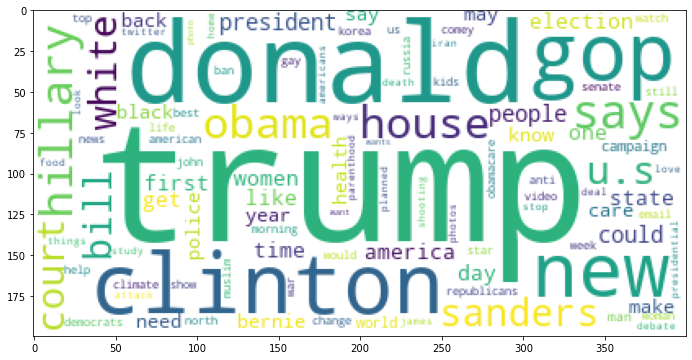

In [17]:
import wordcloud
import matplotlib.pyplot as plt
frequencies = {}
buckets =resp['aggregations']['grupos']['buckets']
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(cloud)

### 4.3 Busca Geral

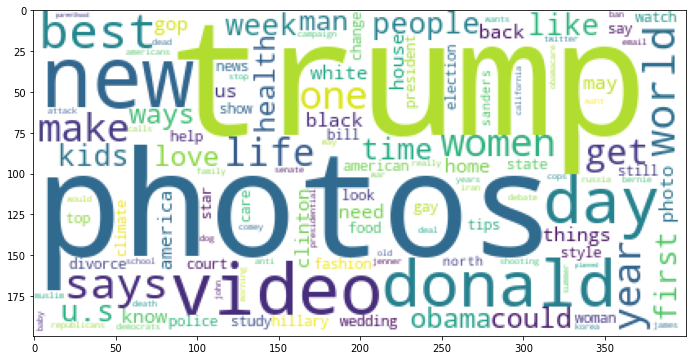

In [18]:
QUERY = {
     'match_all': {}
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'headline',
            'size': 2000000
        },
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)
frequencies = {}
buckets =resp['aggregations']['grupos']['buckets']
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(cloud)

##  <span style="color:purple">4. More Like This</span>

The More Like This Query finds documents that are "like" a given set of documents. In order to do so, MLT selects a set of representative terms of these input documents, forms a query using these terms, executes the query and returns the results. The user controls the input documents, how the terms should be selected and how the query is formed [https://www.elastic.co/guide/en/elasticsearch/reference/8.2/query-dsl-mlt-query.html].

Pode ser utilizada por exemplo para encontrar informações aproximadas, por exemplo, a busca por "president"

In [168]:
QUERY = {
    'more_like_this': {
        'fields': ['headline', 'short_description'],
        'like':"president",
        'min_term_freq': 1,
        'max_query_terms': 12,
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, size=10)
df_resp = pd.DataFrame(x['_source'] for x in resp['hits']['hits'])
df_resp

,category,headline,authors,link,short_description,date
0,POLITICS,Not Even Donald Trump Can Believe He's President,Igor Bobic,https://www.huffingtonpost.com/entry/donald-tr...,"""I’m president ― hey, I’m president!""",2017-05-04T00:00:00
1,POLITICS,Wednesday's Morning Email: Why Obama May Be Kn...,Lauren Weber,https://www.huffingtonpost.com/entry/wednesday...,"The president has commuted 1,385 sentences, th...",2017-01-18T00:00:00
2,COMEDY,Stephen Colbert Just Wants Donald Trump's Lawy...,Ron Dicker,https://www.huffingtonpost.com/entry/stephen-c...,"He calls Jay Sekulow ""the President Trump of t...",2017-06-20T00:00:00
3,POLITICS,How Obama's 'Brutal' First Job Inspired A New ...,Chris D'Angelo,https://www.huffingtonpost.com/entry/obama-fir...,Before Obama was president of the United State...,2016-02-28T00:00:00
4,POLITICS,Emmanuel Macron Dropped Onto A Nuclear Sub And...,Lee Moran,https://www.huffingtonpost.com/entry/emmanuel-...,"""Now that's a President!""",2017-07-06T00:00:00
5,POLITICS,Not Even Mike Pence Can Defend Trump's Wiretap...,Sam Levine,https://www.huffingtonpost.com/entry/mike-penc...,“I think the president’s tweet speaks for itse...,2017-03-07T00:00:00
6,PARENTING,Table Talk: Solar Panels At The White House,Mandy Velez,https://www.huffingtonpost.com/entry/table-tal...,President Carter actually installed solar pane...,2013-08-30T00:00:00
7,POLITICS,Obama Urges Russia To Stop Bombing 'Moderate' ...,,https://www.huffingtonpost.com/entry/obama-rus...,The president spoke with Russian President Vla...,2016-02-14T00:00:00
8,POLITICS,Nancy Pelosi Calls For Sean Spicer's Ouster Am...,Igor Bobic,https://www.huffingtonpost.com/entry/nancy-pel...,"""Either he is speaking for the president, or t...",2017-04-11T00:00:00
9,POLITICS,Tuesday's Morning Email: Everything You Need T...,Lauren Weber,https://www.huffingtonpost.com/entry/tuesdays-...,And what it means for President,2017-03-21T00:00:00


In [169]:
df_resp.iloc[0].T

category                                                      POLITICS
headline              Not Even Donald Trump Can Believe He's President
authors                                                     Igor Bobic
link                 https://www.huffingtonpost.com/entry/donald-tr...
short_description                "I’m president ― hey, I’m president!"
date                                               2017-05-04T00:00:00
Name: 0, dtype: object

In [170]:
df_resp ['headline'].iloc[0]

"Not Even Donald Trump Can Believe He's President"

### Classificador KNN com More like this

Os metodos abaixo criam o classificador da seguinte forma, inicialmente seleciona uma quantidade de documentos.
Para utilizar o more like this para obter uma quantidade de documentos visinhos e 
classificar com base na categória do documento selecionado, com base na categória com maior score dos vizinhos.

In [347]:
def classify_document(doc_id, size=10):
    return classify_with_score(
        [
            {
                '_index': INDEX_NAME,
                '_id': doc_id
            }
        ]
    )

def classify_with_score(like, size=10):
    
    query = {
        'more_like_this': {
            'fields': ["headline"],
            'like':like,
            'min_term_freq': 1,
            'max_query_terms': 12,
            'minimum_should_match': -100,
        }
    }
    resp = client.search(index=INDEX_NAME, query=query, size=size)
    resp_df = pd.DataFrame(
            {
                '_id': x['_id'],
                '_score': x['_score'],
                **x['_source']
            } for x in resp['hits']['hits']
        )

    
    return resp_df.groupby('category').sum().sort_values('_score', ascending=False).index[0]
    

Seleciona uma quantidade de documentos, por exemplo, 100. Sem uma query, uma seleção qualquer.

In [348]:
test_docs_resp = client.search(index=INDEX_NAME, size=100, _source=['category'])
test_docs_resp['hits']['hits']

[{'_index': 'news_category_detection',
  '_id': 'JMRGkoEBE8fvlEs2esV1',
  '_score': 1.0,
  '_source': {'category': 'WORLD NEWS'}},
 {'_index': 'news_category_detection',
  '_id': 'JcRGkoEBE8fvlEs2esV1',
  '_score': 1.0,
  '_source': {'category': 'WORLD NEWS'}},
 {'_index': 'news_category_detection',
  '_id': 'KsRGkoEBE8fvlEs2esV1',
  '_score': 1.0,
  '_source': {'category': 'POLITICS'}},
 {'_index': 'news_category_detection',
  '_id': 'LMRGkoEBE8fvlEs2esV1',
  '_score': 1.0,
  '_source': {'category': 'ENTERTAINMENT'}},
 {'_index': 'news_category_detection',
  '_id': 'LsRGkoEBE8fvlEs2esV1',
  '_score': 1.0,
  '_source': {'category': 'POLITICS'}},
 {'_index': 'news_category_detection',
  '_id': 'L8RGkoEBE8fvlEs2esV1',
  '_score': 1.0,
  '_source': {'category': 'HEALTHY LIVING'}},
 {'_index': 'news_category_detection',
  '_id': 'McRGkoEBE8fvlEs2esV1',
  '_score': 1.0,
  '_source': {'category': 'GREEN'}},
 {'_index': 'news_category_detection',
  '_id': 'NMRGkoEBE8fvlEs2esV1',
  '_score': 1

Cria um dataframe para os documentos de teste

In [349]:
test_docs = pd.DataFrame(
        {
            '_id': x['_id'],
            **x['_source']
        } for x in test_docs_resp['hits']['hits']
    )
test_docs['category'].value_counts()

POLITICS          30
ENTERTAINMENT     15
QUEER VOICES       7
PARENTS            6
HEALTHY LIVING     5
TASTE              5
BLACK VOICES       5
WORLD NEWS         4
GREEN              3
IMPACT             3
STYLE              3
WOMEN              2
LATINO VOICES      2
COMEDY             2
ARTS & CULTURE     2
CRIME              2
WEIRD NEWS         1
TECH               1
BUSINESS           1
MEDIA              1
Name: category, dtype: int64

In [350]:
test_docs['predicted'] = test_docs['_id'].apply(classify_document)

Aplica o metodo para classify_document que chama o metodo classify_with_score que executa o uma consulta more like this passando o
id do documento no like. No metodo vai executar a consulta passando um id, receber os 10 vizinhos mais proximos, criar um dataframe com o resultado e agrupar pelas categorias somando os scores. 

In [351]:
QUERY = {
    'more_like_this': {
        'fields': ["headline^2", "short_description"],
        'like': [
            {
                '_index': INDEX_NAME,
                '_id': 'JMRGkoEBE8fvlEs2esV1',
            }
        ],
        'min_term_freq': 1,
        'max_query_terms': 12,
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, size=10)
resp_df = pd.DataFrame({'_id': x['_id'], '_score': x['_score'], **x['_source']} for x in resp['hits']['hits'])
resp_df.groupby('category').sum()

,_score
category,
IMPACT,10.742830
RELIGION,28.399612
THE WORLDPOST,52.449592
WORLD NEWS,16.645844
WORLDPOST,27.815998


Um pequeno ajuste precisou ser feito no metodo, primeiro, ordenar a o dataframe pelo score, para que o registro com maior score fique primeiro.
E posteriomente retornar a categoria com maior score.

In [352]:
resp_df.groupby('category').sum().sort_values('_score', ascending=False)

,_score
category,
THE WORLDPOST,52.449592
RELIGION,28.399612
WORLDPOST,27.815998
WORLD NEWS,16.645844
IMPACT,10.742830


Com as classification_report calcular as metricas de resultados. Os resultados não foram bons, o dataframe possui muitas catgorias e as informações textuais são curtas para se definir.

In [ ]:
Os resultados obtivos com a classificação foram muito baixos, mas porque o dataset possui muito categórias, que são muito semelhantes até
como por exemplo: WORLD NEWS, THE WORLDPOST e THE WORLDPOST

In [353]:
from sklearn.metrics import classification_report
print(
    classification_report(
        test_docs['category'],
        test_docs['predicted']
    )
)

                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00         0
ARTS & CULTURE       0.00      0.00      0.00         2
  BLACK VOICES       0.00      0.00      0.00         5
      BUSINESS       0.00      0.00      0.00         1
        COMEDY       0.67      1.00      0.80         2
         CRIME       0.40      1.00      0.57         2
 ENTERTAINMENT       0.90      0.60      0.72        15
   ENVIRONMENT       0.00      0.00      0.00         0
  FOOD & DRINK       0.00      0.00      0.00         0
         GREEN       0.00      0.00      0.00         3
HEALTHY LIVING       1.00      0.20      0.33         5
 HOME & LIVING       0.00      0.00      0.00         0
        IMPACT       0.00      0.00      0.00         3
 LATINO VOICES       0.50      0.50      0.50         2
         MEDIA       1.00      1.00      1.00         1
     PARENTING       0.00      0.00      0.00         0
       PARENTS       1.00      0.33      0.50  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_cla

### 4.2 Problema Observado

Também existe um problema nesse classificador, da forma em que esta. Existe casos em que a consulta não retorna nenhum hit, dessa
forma o metodo de classificação retorna uma exeção.

In [323]:

def ajusta_retorno(resp):
    
    resp_df = pd.DataFrame(
                {
                    '_id': x['_id'],
                    '_score': x['_score'],
                    **x['_source']
                } for x in resp['hits']['hits']
            )
    return resp_df.groupby('category').sum().sort_values('_score', ascending=False).index[0]


def busca_outros_parametros(doc, size=10):
    #like= [doc['headline'], doc['short_description']] 
    like= {
         '_index': INDEX_NAME,
         '_id': doc['_id']
            }
    query = {
            'more_like_this': {
            'fields': ['short_description'],
            'like':like,
            'minimum_should_match': -100,
            'min_term_freq': 1,
            'max_query_terms': 12,
        }
        }
    resp = client.search(index=INDEX_NAME, query=query, size=size)
    if(resp['hits']['total']['value']>0):
        print(resp['hits']['total']['value'])
        return ajusta_retorno(resp)
    else:
        return outra_busca(doc)

    
def outra_busca(doc):
    print(doc['_id'])
    

def classify_with_score(doc, size=10):
    #print(doc)
    like= {
         '_index': INDEX_NAME,
         '_id': doc['_id']
            }
    
    query = {
        'more_like_this': {
            'fields': ["headline"],
            'minimum_should_match': -100,
            'like':like,
            'min_term_freq': 1,
            'max_query_terms': 12,
        }
    }
    resp = client.search(index=INDEX_NAME, query=query, size=size)
    if(resp['hits']['total']['value']>0):
        return ajusta_retorno(resp)
        
    else:
        return busca_outros_parametros(doc)
    

In [324]:
test_docs_resp = client.search(index=INDEX_NAME, size=5000, _source=['category', 'headline', 'short_description', 'authors'])
test_docs = pd.DataFrame({'_id': x['_id'], **x['_source']} for x in test_docs_resp['hits']['hits'])
test_docs['predicted']=test_docs.apply(classify_with_score, axis=1)
#print(classification_report(test_docs['category'],test_docs['predicted']))


4sRGkoEBE8fvlEs2gcqA
NcRGkoEBE8fvlEs2iOK7


In [322]:
from sklearn.metrics import classification_report
print(
    classification_report(
        test_docs['category'],
        test_docs['predicted']
    )
)

TypeError: '<' not supported between instances of 'NoneType' and 'str'

In [136]:
QUERY = {
    'term': {
        '_id': 'a8RGkoEBE8fvlEs2g9Fq'
    }
}

resp = client.search(index=INDEX_NAME, query=QUERY, size=1)
doc=resp['hits']['hits'][0]
doc

{'_index': 'news_category_detection',
 '_id': 'a8RGkoEBE8fvlEs2g9Fq',
 '_score': 1.0,
 '_source': {'category': 'POLITICS',
  'headline': "Don't Believe The Hype: Obama's Limited Restrictions On Military Equipment For Cops Were Reasonable",
  'authors': 'Roy L. Austin, Jr., ContributorFormer Deputy Assistant to President Obama for the Office of U...',
  'link': 'https://www.huffingtonpost.com/entry/dont-believe-the-hype-obamas-limited-restrictions-on-military-equipment-for-cops-were-reasonable_us_59a4621ee4b0821444c52f27',
  'short_description': 'Reversing the policy is yet another Trump administration decision based on alternative facts.',
  'date': '2017-08-28T00:00:00'}}

In [134]:
classify_with_score(doc)

KeyError: 'headline'

In [673]:
headline= "Asian-American Pastor's Arrest In China Comes Amid Crackdown On Unsanctioned House Churches"
short_description= 'Experts say John Cao’s arrest and subsequent sentencing could be part of the ruling Communist Party’s attempts to exert authority over independent Christian churches.'
authors= 'Carol Kuruvilla'

like = [
   # {
       # '_index': INDEX_NAME,
        #'_id': '57YMjIEBE8fvlEs27Muu',
    #}, 
    headline,
    short_description, 
    authors
]
#classify_with_score(like, size=1)

query = {
        'more_like_this': {
            'fields': ["headline"],
            'like':like,
            'min_term_freq': 1,
            'max_query_terms': 12,
        }
    }
resp = client.search(index=INDEX_NAME, query=query, size=100)
resp['hits']['total']['value']


1

In [137]:
like = [
    {
        '_index': INDEX_NAME,
        '_id': 'a8RGkoEBE8fvlEs2g9Fq',
    }
]
#classify_with_score(like, size=1)

query = {
        'more_like_this': {
            'fields': ["headline"],
            'like':like,
            'min_term_freq': 1,
            'max_query_terms': 12,
        }
    }
resp = client.search(index=INDEX_NAME, query=query, size=10)
resp['hits']['total']['value']

26

In [320]:
def classify_with_score_teste(doc, size=10):
    print(doc['_id'])
    like= {
         '_index': INDEX_NAME,
         '_id': doc['_id']
            }
    
    query = {
        'more_like_this': {
            'fields': ["headline"],
            'like':like,
            'minimum_should_match': -100,
            'min_term_freq': 1,
            'max_query_terms': 12,
        }
    }
    resp = client.search(index=INDEX_NAME, query=query, size=size)
    #print(resp['hits'])
    if(resp['hits']['total']['value']>0):
        print(resp['hits']['total']['value'])
        return ajusta_retorno(resp)
    else:
        return busca_outros_parametros(doc)

In [270]:
classify_with_score_teste(doc)

557


'POLITICS'

In [556]:
from sklearn.metrics import classification_report

In [557]:
print(
    classification_report(
        test_docs['category'],
        test_docs['predicted']
    )
)

                precision    recall  f1-score   support

ARTS & CULTURE       0.00      0.00      0.00         9
  BLACK VOICES       0.45      0.28      0.35        32
      BUSINESS       0.33      0.36      0.35        11
       COLLEGE       0.00      0.00      0.00         2
        COMEDY       0.72      0.58      0.64        57
         CRIME       0.56      0.50      0.53        18
       DIVORCE       0.00      0.00      0.00         0
     EDUCATION       0.00      0.00      0.00         3
 ENTERTAINMENT       0.66      0.65      0.65       171
         FIFTY       0.00      0.00      0.00         0
  FOOD & DRINK       0.00      0.00      0.00         0
     GOOD NEWS       0.00      0.00      0.00         0
         GREEN       0.64      0.33      0.44        27
HEALTHY LIVING       0.42      0.25      0.31        20
 HOME & LIVING       0.00      0.00      0.00         0
        IMPACT       0.25      0.11      0.15         9
 LATINO VOICES       0.67      0.14      0.24  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_cla

In [104]:
df = pd.DataFrame([[4, 9]] * 3, columns=['A', 'B'])
df

,A,B
0,4,9
1,4,9
2,4,9


In [105]:
df.apply(lambda x: [1, 2], axis=1, result_type='expand')
df

,A,B
0,4,9
1,4,9
2,4,9


In [ ]:
psRGkoEBE8fvlEs2esV1

In [317]:
like= {
         '_index': INDEX_NAME,
         '_id': 'qsRGkoEBE8fvlEs2esV1'
            }
    
query = {
        'more_like_this': {
            'fields': ["headline", "short_description"],
            'like':like,
            'min_term_freq': 1,
            'minimum_should_match': -100,
            'max_query_terms': 12,
        }
    }
resp = client.search(index=INDEX_NAME, query=query, size=10)
    #print(resp['hits'])
resp

ObjectApiResponse({'took': 5, 'timed_out': False, '_shards': {'total': 3, 'successful': 3, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 2019, 'relation': 'eq'}, 'max_score': 19.954424, 'hits': [{'_index': 'news_category_detection', '_id': 'C8VGkoEBE8fvlEs2rU3T', '_score': 19.954424, '_source': {'category': 'COMEDY', 'headline': 'Martin Shkreli Will Need Ointment After This Sick Burn From Colbert', 'authors': 'Andy McDonald', 'link': 'https://www.huffingtonpost.com/entry/martin-shkreli-will-need-ointment-after-this-sick-burn-from-colbert_us_57c452d5e4b09cd22d9179d6', 'short_description': "Hopefully no one's inflated the price of ointment for you, Martin.", 'date': '2016-08-29T00:00:00'}}, {'_index': 'news_category_detection', '_id': 'a8VGkoEBE8fvlEs2nha6', '_score': 18.226522, '_source': {'category': 'COMEDY', 'headline': 'Stephen Colbert Is Sick Of Donald Trump Stealing His Act', 'authors': 'Lee Moran', 'link': 'https://www.huffingtonpost.com/entry/stephen-colbert-trump-on-n

In [319]:
resp['hits']['hits']

[{'_index': 'news_category_detection',
  '_id': 'C8VGkoEBE8fvlEs2rU3T',
  '_score': 19.954424,
  '_source': {'category': 'COMEDY',
   'headline': 'Martin Shkreli Will Need Ointment After This Sick Burn From Colbert',
   'authors': 'Andy McDonald',
   'link': 'https://www.huffingtonpost.com/entry/martin-shkreli-will-need-ointment-after-this-sick-burn-from-colbert_us_57c452d5e4b09cd22d9179d6',
   'short_description': "Hopefully no one's inflated the price of ointment for you, Martin.",
   'date': '2016-08-29T00:00:00'}},
 {'_index': 'news_category_detection',
  '_id': 'a8VGkoEBE8fvlEs2nha6',
  '_score': 18.226522,
  '_source': {'category': 'COMEDY',
   'headline': 'Stephen Colbert Is Sick Of Donald Trump Stealing His Act',
   'authors': 'Lee Moran',
   'link': 'https://www.huffingtonpost.com/entry/stephen-colbert-trump-on-notice_us_58945dace4b0406131364338',
   'short_description': 'He claims the president keeps ripping off his ideas.',
   'date': '2017-02-03T00:00:00'}},
 {'_index': 'ne

In [ ]:
def busca_outros_parametros(doc, size=10):
    like= [doc['headline'], doc['short_description']] 
    query = {
            'more_like_this': {
            'fields': ["headline^2", "short_description"],
            'like':like,
            'min_term_freq': 1,
            'max_query_terms': 12,
        }
        }
    resp = client.search(index=INDEX_NAME, query=query, size=size)
    if(resp['hits']['total']['value']>0):
        print(resp['hits']['total']['value'])
        return ajusta_retorno(resp)
    else:
        return outra_busca(doc)


In [329]:
test_docs_resp = client.search(index=INDEX_NAME, size=5)
test_docs = pd.DataFrame(
        {
            '_id': x['_id'],
            **x['_source']
        } for x in test_docs_resp['hits']['hits']
    )
test_docs

,_id,category,headline,authors,link,short_description,date
0,JMRGkoEBE8fvlEs2esV1,WORLD NEWS,The Transformation Of Jerusalem,"James Zogby, ContributorPresident, Arab Americ...",https://www.huffingtonpost.com/entry/the-trans...,The Israeli construct—“Greater Jerusalem”—is a...,2017-10-07T00:00:00
1,JcRGkoEBE8fvlEs2esV1,WORLD NEWS,"North Korea Really Isn’t China’s Fault, Though...","Doug Bandow, ContributorContributing writer, p...",https://www.huffingtonpost.com/entry/north-kor...,Chinese officials bemoan their lack of influen...,2017-10-07T00:00:00
2,KsRGkoEBE8fvlEs2esV1,POLITICS,Gunfight At The Second Amendment Corral,"David Schultz, ContributorProfessor of Politic...",https://www.huffingtonpost.com/entry/gunfight-...,Like it or not the Second Amendment exists and...,2017-10-07T00:00:00
3,LMRGkoEBE8fvlEs2esV1,ENTERTAINMENT,BTS Earns Highest Ever Spot On Billboard Hot 1...,Doha Madani,https://www.huffingtonpost.com/entry/bts-billb...,BTS already made history by being the first K-...,2017-10-07T00:00:00
4,LsRGkoEBE8fvlEs2esV1,POLITICS,Bill Maher: I'm So Sick Of 'Thoughts And Praye...,Lee Moran,https://www.huffingtonpost.com/entry/bill-mahe...,"""Thoughts and prayers are the Republican way o...",2017-10-07T00:00:00


In [338]:
QUERY = {
    'more_like_this': {
        'fields': ['headline^2', 'short_description'],
        'like': [
            {
                '_index': INDEX_NAME,
                '_id': test_docs['_id'].iloc[0],
            }
        ],
        'min_term_freq': 1,
        'max_query_terms': 12,
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, size=10)
resp_df = pd.DataFrame({'_id': x['_id'], '_score': x['_score'], **x['_source']} for x in resp['hits']['hits'])
resp_df.groupby('category').sum().sort_values('_score', ascending=False)

,_score
category,
THE WORLDPOST,52.449592
RELIGION,28.399612
WORLDPOST,27.815998
WORLD NEWS,16.645844
IMPACT,10.742830


In [342]:
import pandas as pd
df_data = pd.read_csv('../Data/archive6/bbc-news-data.csv', sep='\t')
df_data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [343]:
df_data.keys()

Index(['category', 'filename', 'title', 'content'], dtype='object')

In [344]:
df_data['title'].iloc[0]

'Ad sales boost Time Warner profit'

In [345]:
df_data['content'].iloc[0]

' Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL\'s existing customers for high-